# DATA SCIENCE APLICADA | ANÁLISE DE SÉRIES TEMPORAIS
***



**DESAFIO - MÓDULO 04**

Neste projeto do módulo 4 vamos trabalhar com a base de dados de casos de COVID-19, os impactos desta pandemia trouxe e ainda pode trazer consequências sem precedentes na sociedade moderna.

O foco deste projeto será analisar os casos de COVID-19 em uma perspectiva de Séries Temporais. Convidamos você a realizar uma análise dos dados, discutir suas estatísticas e desenvolver um modelo preditivo para prever o número de casos. Esse será os objetivos principais do projeto, mas sita-se livre para ir além do que estamos pedindo, o DATASUS tem muitas informações além dos número de casos e óbitos.

- Os dados atualizados oficialmente pelo Ministério do Saúde você acessa por este link.

- Dados relacionados a SRAG para enriquecer sua análise você encontra neste link

- Neste link você encontra várias outras informações relacionadas a COVID-19 para inspirar suas análises.

# O PROJETO

## IMPORTAÇÃO DAS LIB's

In [1]:
import os 

import pandas                      as pd 
import seaborn                     as sns
import numpy                       as np

import matplotlib
import matplotlib.pyplot           as plt
import matplotlib.ticker           as ticker
import matplotlib.dates            as mdates

from pandas.plotting               import autocorrelation_plot
from matplotlib.dates              import DateFormatter
from statsmodels.tsa.seasonal      import seasonal_decompose
from statsmodels.tsa.stattools     import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api           import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model   import ARIMA

import warnings
warnings.filterwarnings('ignore')

## HELPER FUNCTIONS


In [2]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]




## DATASET's

### DADOS CORONAVIRUS

Os dados referente aos novos casos, casos acumulados, óbitos, etc., foram extraídos da plataforma do Ministério da Saúde, veículo oficial de comunicação sobre a situação epidemiológica da COVID-19 no Brasil.

A extração foi feita em 19/01/21.

Dataset disponível em: https://covid.saude.gov.br/

In [3]:
covid = pd.read_csv(r'/Users/daianeklein/Documents/Desafio-COVID/Dados/HIST_PAINEL_COVIDBR_19jan2021.csv',
                   encoding='latin-1', sep=';')

In [4]:
covid['casosNovos'].sort_values().head(10)

3495      -7926
294949    -2407
277241    -1812
745666    -1787
277210    -1370
3801      -1349
985101    -1314
359210     -901
489295     -712
1564504    -656
Name: casosNovos, dtype: int64

In [5]:
# Foram identificados valores negativos na coluna 'casosNovos', assim, serão substituídos pelo
# valor anterior no dataframe 

covid['casosNovos'] = covid['casosNovos'].where(covid['casosNovos'].ge(0)).ffill()

# Verificando se está correto
print(covid['casosNovos'].loc[3495])
print(covid['casosNovos'].loc[359210])
print(covid['casosNovos'].loc[1564504])

10433.0
1254.0
656.0


In [6]:
# Separando os dados por UF

# Criando uma lista com as UF
uf = ['AC','AL','AP','AM','BA','CE','DF','ES','GO','MA','MT','MS','MG','PA',
'PB','PR','PE','PI','RJ','RN','RS','RO','RR','SC','SP','SE','TO']

# Retirando valores duplicados (base de dados possui por estado e tbm por municipio)
covid = covid[covid['municipio'].isnull()]

# Selecionando as colunas alvo
colunas = ['regiao', 'estado', 'data','casosAcumulado', 'casosNovos', 'obitosAcumulado', 'obitosNovos']

covid = covid[colunas]
covid = covid[covid['estado'].isin(uf)]

covid.sample(10)

,regiao,estado,data,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
4499,Nordeste,PE,2020-09-19,141042,807.0,8004,33
8393,Centro-Oeste,MT,2020-07-15,30319,1040.0,1174,69
4411,Nordeste,PE,2020-06-23,52831,337.0,4339,87
50285,Norte,RR,2020-06-15,88,0.0,2,0
1947,Norte,PA,2020-12-16,282719,1052.0,7018,5
5784,Sudeste,MG,2020-08-15,171514,3086.0,4044,101
1761,Norte,PA,2020-06-13,68510,2182.0,4177,45
1564490,Centro-Oeste,MT,2020-08-23,0,0.0,0,0
277437,Nordeste,CE,2021-01-12,6333,4.0,0,0
5484,Nordeste,BA,2020-09-14,283235,718.0,5999,38


### PROJEÇÃO DA POPULAÇÃO DO BRASIL POR SEXO E IDADE SIMPLES: 2000-2060

A projeção da população do Brasil é um estudo feito pelo IBGE de fundamental importância para cálculo de indicadores sociodemográficos, elaboração de políticas públicas, bem como estratégias de planejamento do setor privado.

As Projeções da População do Brasil e das Unidades da Federação são elaboradas com base nas informações sobre as componentes da dinâmica demográfica oriundas dos censos demográficos, das pesquisas domiciliares por amostragem e dos registros administrativos de nascimentos e óbitos investigados pelo IBGE. (Fonte IBGE)

O arquivo utilizado neste notebook está disponível em: http://tabnet.datasus.gov.br/cgi/deftohtm.exe?ibge/cnv/projpopbr.def

In [7]:
# importação do dataset de populacao estimada
populacao = pd.read_csv(r'/Users/daianeklein/Documents/Desafio-COVID/Dados/POPULACAO.csv',
                       encoding='latin-1', sep = ';', skiprows=3, skipfooter=4, engine='python') 

#index que serão excluídos
excluir = ['Região Norte','Região Sudeste','Região Sul','Região Centro-Oeste','Total','Região Nordeste', ' Fonte:']

# Definindo os indices
populacao.set_index('Região/Unidade da Federação', inplace=True)

# Excluindo as linhas
populacao.drop(excluir, inplace = True)

### CNES - RECURSOS FÍSICOS - HOSPITALAR - LEITOS DE INTERNAÇÃO - BRASIL

O CNES é a sigla para Cadastro Nacional de Estabelecimentos de Saúde, instituído pelo Ministério da Saúde e responsável pelo cadastro de dados de estabelecimentos que prestem assistência à saúde, seja público ou privado.

O objetivo do CNES é manter o cadastro de todos os estabelecimentos de saúde, hospitalares e ambulatoriais (consultório médico ou
odontológico isolado, consultórios de psicologia, fisioterapia, policlínicas, clinicas especializadas,
laboratórios, serviços de diagnose e terapia ou, ainda, unidade de Vigilância Sanitária ou
epidemiológica), mantendo-os atualizados para servir de suporte à estratégias e planos relacionados à saúde.

**Neste estudo, foram considerados os leitos de internação públicos e privados**

http://tabnet.datasus.gov.br/cgi/tabcgi.exe?cnes/cnv/leiintbr.def

In [8]:
leitos = pd.read_csv(r'/Users/daianeklein/Documents/Desafio-COVID/Dados/leitos.csv',
                       encoding='latin-1', sep = ';', skiprows=3, skipfooter=12, engine='python')

#index que serão excluídos
excluir = ['Região Norte','Região Sudeste','Região Sul','Região Centro-Oeste','Região Nordeste' ]

# Definindo os índices
leitos.set_index('Região/Unidade da Federação', inplace = True)

#Excluindo as linhas
leitos.drop(excluir, inplace = True)


### PROCEDIMENTOS HOSPITALARES DO SUS - POR LOCAL DE INTERNAÇÃO - BRASIL

Os dados referente aos procedimentos hospitalares são disponibilizados pelo Ministério da Saúde através da plataforma DATASUS. 

Para esta análise, foram considerados os procedimentos por local de internação e por data de processamento.
Também foram utilizados somente os atendimentos de emergência (uma vez que o foco é COVID, foram expurgados atendimentos relacionados à acidente de trabalho, trânsito, produtos químicos, etc).

http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sih/cnv/qiuf.def

In [9]:
internacoes = pd.read_csv(r'/Users/daianeklein/Documents/Desafio-COVID/Dados/INTERNACOES.csv',
                       encoding='latin-1', sep = ';', skiprows=4, skipfooter=12, engine='python')

#index que serão excluídos
excluir = ['Região Norte','Região Sudeste','Região Sul','Região Centro-Oeste','Região Nordeste', ]

# Definindo os índices
internacoes.set_index('Região/Unidade da Federação', inplace = True)

#Excluindo as linhas
internacoes.drop(excluir, inplace = True)

internacoes

,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,2009/Out,...,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,Total
Região/Unidade da Federação,,,,,,,,,,,,,,,,,,,,,
.. Rondônia,5891,6608,6950,6857,7343,7032,6950,6792,6739,7134,...,8120,6498,6671,5883,7266,7228,7227,6089,5942,1082097
.. Acre,2493,2258,2264,2482,2443,2252,2169,2194,-,2373,...,2220,1831,1667,1830,1975,2192,2007,2651,2012,318843
.. Amazonas,8076,7550,10923,9855,9699,9123,9518,9736,10267,9920,...,13742,11514,12722,13301,12970,11930,13380,12285,11474,1609758
.. Roraima,1909,1625,1809,1962,2500,2072,2137,2482,2612,1814,...,3119,2848,2685,2630,2565,2889,2708,3254,2873,384759
.. Pará,37798,37466,40237,39580,39517,38518,42550,41660,41923,41556,...,35157,28291,27728,30235,30581,34738,30550,29206,27309,5276252
.. Amapá,2401,2630,2531,2771,2338,2258,2305,2229,2305,2345,...,1865,1602,1751,2053,2681,2606,2398,1778,1903,329532
.. Tocantins,7005,7570,7485,7421,7666,7718,7335,7394,7454,7454,...,6255,5897,5995,5765,6430,6056,5841,5863,5628,971293
.. Maranhão,19031,20516,21625,22096,22010,22252,22866,23362,24323,24416,...,29746,24830,25523,25054,26568,26018,25316,24775,22285,3956202
.. Piauí,15556,15397,16410,17209,17934,18614,17988,17159,17128,16748,...,13993,11632,12193,13099,13903,14437,12881,13449,8053,2252776


In [10]:
despesas = pd.read_csv('despesas.csv', sep=';', encoding='UTF-8')
despesas 

,LOCALIDADE,2016,2017,2018,2019,2020
0,Acre,295084471,"296810594,4","356892876,3","370052003,6",432255159
1,Alagoas,1085344451,1115745214,1357440089,1469948488,1482194788
2,Amapá,"213565337,5","207071360,6","250371774,5","244969340,1","385382870,2"
3,Amazonas,"914760077,6","903687628,1","993738417,4",1085240205,1275896645
4,Bahia,4255454408,4320569086,4901940202,5273034706,5624715575
5,Ceará,2777013793,2957495853,3262145797,3567192479,3687313681
6,Distrito Federal,7739009392,7986980907,7233719959,6749097566,6107228349
7,Espírito Santo,1055926663,1101778678,1223234672,1351502879,1373350234
8,Goiás,1800106720,1831349004,2066091021,2277628619,2455398948
9,Maranhão,1928363298,1978617665,2262914387,2426943630,2489307917


### TRANFORMAÇÃO DOS DADOS



In [11]:
# Alteração do tipo de dado
covid['data'] = covid['data'].astype('datetime64')

In [12]:
# Criação de uma coluna com dia, mes e ano
covid['dia'] = covid['data'].dt.day
covid['mes'] = covid['data'].dt.month
covid['ano'] = covid['data'].dt.year

## ANÁLISES MACROS

### COVID

In [13]:
novos_casos = covid[['data', 'casosNovos']].groupby('data').sum().reset_index()

<Figure size 432x288 with 0 Axes>

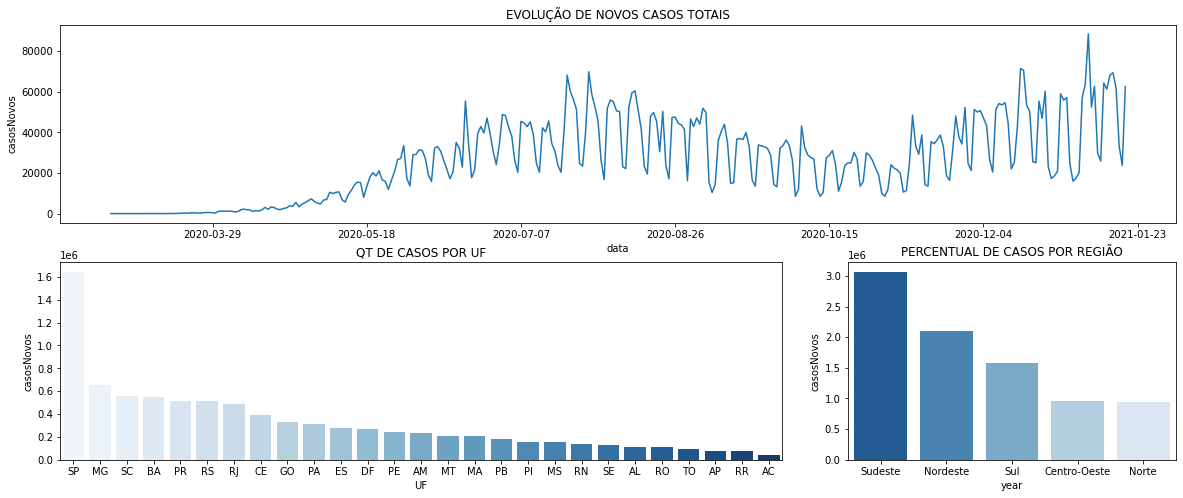

In [14]:
fig3 = plt.figure(constrained_layout=True)
fig3 = plt.figure(figsize=(20,8))

#######


gs = fig3.add_gridspec(2, 3) ## number of charts


graph1 = fig3.add_subplot(gs[0, :]) ##chart 1
graph1.set_title('EVOLUÇÃO DE NOVOS CASOS TOTAIS')
graph1 = sns.lineplot(data=novos_casos, x='data', y='casosNovos', 
                      palette='Blues')
graph1.xaxis.set_major_locator(ticker.AutoLocator())


#######

c = covid[['estado', 'casosNovos']].groupby('estado').sum().reset_index().sort_values(by='casosNovos',
                                                                                     ascending=False)

graph2 = fig3.add_subplot(gs[1, :-1])
graph2.set_title('QT DE CASOS POR UF')
graph2 = sns.barplot(data = c, x = 'estado', y='casosNovos', 
                     palette = 'Blues')
graph2 = plt.xlabel('UF')


#######
b = data = covid[['regiao', 'casosNovos']].groupby('regiao').sum().reset_index().sort_values(by='casosNovos', ascending=False)

graph3 = fig3.add_subplot(gs[1:, -1])
graph3.set_title('PERCENTUAL DE CASOS POR REGIÃO')
graph3 = sns.barplot(data = b, x='regiao', y='casosNovos',palette='Blues_r')
graph3 = plt.xlabel('year')


#######

fig3 = fig3



<Figure size 432x288 with 0 Axes>

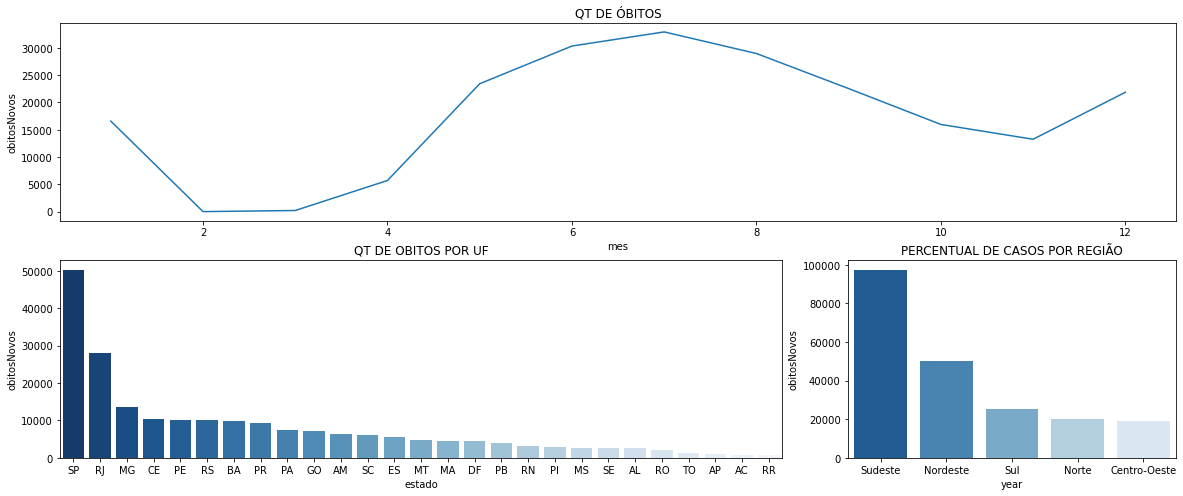

In [15]:
fig3 = plt.figure(constrained_layout=True)
fig3 = plt.figure(figsize=(20,8))

#######


gs = fig3.add_gridspec(2, 3) ## number of charts

sns.dark_palette("#69d", reverse=True, as_cmap=True)
obitos = covid[['mes', 'obitosNovos']].groupby('mes').sum()
graph1 = fig3.add_subplot(gs[0, :]) ##chart 1
graph1.set_title('QT DE ÓBITOS')
graph1 = sns.lineplot(data=obitos, x='mes', y='obitosNovos',  ci=False)
graph1.xaxis.set_major_locator(ticker.AutoLocator())


#######

obitos_uf = covid[['estado', 'obitosNovos']].groupby('estado').sum().reset_index()
order = obitos_uf.sort_values(by='obitosNovos', ascending=False)['estado']

graph2 = fig3.add_subplot(gs[1, :-1])

graph2.set_title('QT DE OBITOS POR UF')
graph2 = sns.barplot(data = obitos_uf, x ='estado',y='obitosNovos', order = order, palette='Blues_r')



#######

a = covid[['regiao', 'obitosNovos']].groupby('regiao').sum().reset_index().sort_values(by='obitosNovos', 
                                                                                       ascending=False)

graph3 = fig3.add_subplot(gs[1:, -1])
graph3.set_title('PERCENTUAL DE CASOS POR REGIÃO')
graph3 = sns.barplot(data = a, x= 'regiao', y='obitosNovos',
                     palette='Blues_r')
graph3 = plt.xlabel('year')


#######

fig3 = fig3



### COVID x POPULAÇÃO

In [16]:
# ajustando o nome dos estados
populacao.reset_index(inplace = True)
populacao['Região/Unidade da Federação'].replace('.. ', '', inplace = True, regex=True)

# Dicionario com estados e UF
siglas = {
'Acre':'AC',
'Alagoas':'AL',
'Amapá':'AP',
'Amazonas':'AM',
'Bahia':'BA',
'Ceará':'CE',
'DistriFederal':'DF',
'EspíriSanto':'ES',
'Goiás':'GO',
'Maranhão':'MA',
'MaGrosso':'MT',
'MaGrosSul':'MS',
'MinGerais':'MG',
'Pará':'PA',
'Paraíba':'PB',
'Paraná':'PR',
'Pernambuco':'PE',
'Piauí':'PI',
'RJaneiro':'RJ',
'RGranNorte':'RN',
'RGranSul':'RS',
'Rondônia':'RO',
'Roraima':'RR',
'SanCatarina':'SC',
'SPaulo':'SP',
'Sergipe':'SE',
'Tocantins':'TO'
}

# Inserindo a coluna com uf
populacao['uf'] = populacao['Região/Unidade da Federação'].map(siglas)

In [17]:
populacao_e_contagio = populacao[['uf', '2019']]

#qt de casos por UF
covid_por_uf = covid[['estado', 'casosNovos']].groupby('estado').sum().reset_index()
covid_por_uf.rename(columns={'estado' : 'uf'}, inplace=True) # renomeando as colunas

# qt de obitos por UF
obitos_por_uf = covid[['estado', 'obitosNovos']].groupby('estado').sum().reset_index()
obitos_por_uf.rename(columns={'estado' : 'uf'}, inplace=True)

populacao_e_contagio = populacao_e_contagio.merge(covid_por_uf, on='uf', how = 'inner') #inserindo casos
populacao_e_contagio = populacao_e_contagio.merge(obitos_por_uf, on='uf', how = 'inner') #inserindo obitos
populacao_e_contagio.rename(columns={'2019' : 'Populacao_2019'}, inplace=True) #renomeando a coluna 2019

In [18]:
# Calculando a qt de contagio para cada 1k de habitantes
populacao_e_contagio['contagio_1k_habitante'] = (populacao_e_contagio['casosNovos'] /  populacao_e_contagio['Populacao_2019']) * 1000

# Calculando a qt de obitos para cada 1k de habitantes
populacao_e_contagio['mortalidade_1k'] = (populacao_e_contagio['obitosNovos'] /  populacao_e_contagio['Populacao_2019']) * 1000

# Calculando a qt de obitos pela qt. de contagios
populacao_e_contagio['letalidade_1k'] = (populacao_e_contagio['obitosNovos'] / populacao_e_contagio['casosNovos'] ) * 1000

populacao_e_contagio

,uf,Populacao_2019,casosNovos,obitosNovos,contagio_1k_habitante,mortalidade_1k,letalidade_1k
0,RO,1841142.0,111399.0,2044,60.505382,1.110181,18.348459
1,AC,854691.0,45208.0,839,52.893970,0.981641,18.558662
2,AM,4182899.0,233971.0,6450,55.935130,1.541993,27.567519
3,RR,538963.0,73184.0,823,135.786687,1.527006,11.245627
4,PA,8544639.0,311063.0,7427,36.404464,0.869200,23.876192
5,AP,828028.0,74045.0,1010,89.423305,1.219766,13.640354
6,TO,1583391.0,97198.0,1323,61.385975,0.835549,13.611391
7,MA,7083578.0,203998.0,4618,28.798723,0.651930,22.637477
8,PI,3229651.0,152215.0,2968,47.130479,0.918985,19.498735
9,CE,9128090.0,394913.0,10240,43.263487,1.121812,25.929762


<Figure size 432x288 with 0 Axes>

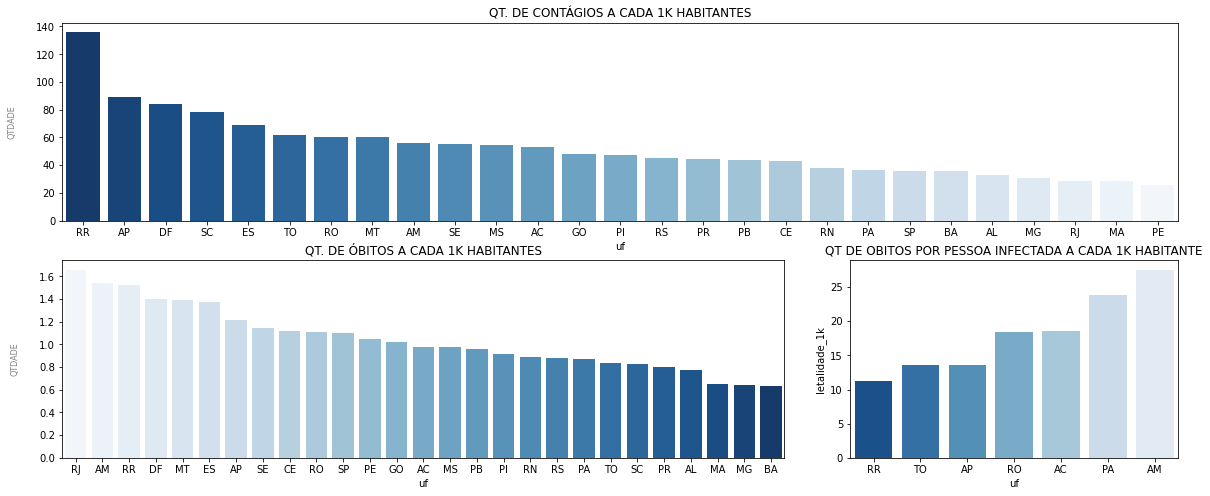

In [19]:
fig3 = plt.figure(constrained_layout=True)
fig3 = plt.figure(figsize=(20,8))

#######


gs = fig3.add_gridspec(2, 3) ## number of charts


graph1 = fig3.add_subplot(gs[0, :]) ##chart 1

graph1.set_title('QT. DE CONTÁGIOS A CADA 1K HABITANTES')
sns.barplot(data = populacao_e_contagio.sort_values('contagio_1k_habitante', ascending=False), x= 'uf', y='contagio_1k_habitante',
                     palette='Blues_r')
plt.ylabel('QTDADE', color = 'grey', labelpad = 20, fontsize = 8)



#######


order = obitos_uf.sort_values(by='obitosNovos', ascending=False)['estado']
graph2 = fig3.add_subplot(gs[1, :-1])
graph2.set_title('QT. DE ÓBITOS A CADA 1K HABITANTES')

graph2= sns.barplot(data = populacao_e_contagio.sort_values('mortalidade_1k', ascending=False), x= 'uf', y='mortalidade_1k', 
                                         palette='Blues')

plt.ylabel('QTDADE', color = 'grey', labelpad = 20, fontsize = 8)


#######

norte = ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO']


graph3 = fig3.add_subplot(gs[1:, -1])
graph3.set_title('QT DE OBITOS POR PESSOA INFECTADA A CADA 1K HABITANTE')
graph3 = sns.barplot(data = populacao_e_contagio[populacao_e_contagio['uf'].isin(norte)].sort_values(by='letalidade_1k'), x= 'uf', y='letalidade_1k',
                     palette='Blues_r')


#######

fig3 = fig3;



In [20]:
populacao_e_contagio[['uf','letalidade_1k']].sort_values(by='letalidade_1k',
                                                                             ascending=False).style.apply(highlight_max)

,uf,letalidade_1k
18,RJ,57.559483
12,PE,41.319395
19,SP,30.569142
2,AM,27.567519
9,CE,25.929762
4,PA,23.876192
10,RN,23.624265
13,AL,23.557273
24,MT,23.236571
7,MA,22.637477


In [21]:
populacao_e_contagio[['uf','mortalidade_1k']].sort_values(by='mortalidade_1k',
                                                                             ascending=False).style.apply(highlight_max)

,uf,mortalidade_1k
18,RJ,1.660868
2,AM,1.541993
3,RR,1.527006
26,DF,1.402709
24,MT,1.396172
17,ES,1.374531
5,AP,1.219766
14,SE,1.146988
9,CE,1.121812
0,RO,1.110181


### LEITOS x POPULAÇÃO

In [22]:
# ajustando o nome dos estados
leitos.reset_index(inplace = True)
leitos['Região/Unidade da Federação'].replace('.. ', '', inplace = True, regex=True)

# Inserindo a coluna com uf
leitos['uf'] = leitos['Região/Unidade da Federação'].map(siglas)

# transformando 'uf' em index
leitos.set_index('uf', inplace=True)

# Excluindo a coluna leitos
leitos.drop(columns=('Região/Unidade da Federação'), inplace=True)

# Slice do ano
# Criando a coluna ano
leitos = leitos.T.reset_index()
leitos['ano'] = leitos['index'].str.slice(start = 0, stop = 4)

# Criando a coluna do mes
leitos['mes'] = leitos['index'].str.slice(start = 5, stop = 8)

In [23]:
# Transformando os meses para ingles
meses_port_ing = {
    "Jan": "Jan",
    "Fev": "Feb",
    "Mar": "Mar",
    "Abr": "Apr",
    "Mai": "May",
    "Jun": "Jun",
    "Jul": "Jul",
    "Ago": "Aug",
    "Set": "Sep",
    "Out": "Oct",
    "Nov": "Nov",
    "Dez": "Dec"
}

# traduzinho os meses
leitos['mes'] = leitos['mes'].map(meses_port_ing)

In [24]:
# Concatenando o ano e mes
leitos['data'] = leitos['ano'] + "-" + leitos['mes']

# Alterando o tipo de dado
leitos['data'] = pd.to_datetime(leitos['data'])

# removendo as colunas
leitos.drop(columns=(['index', 'ano', 'mes']), inplace = True)  

# Fazendo melt
leitos = leitos.melt(id_vars='data', value_name='qt_leitos')

# Criando a coluna de mes e ano
leitos['mes'] = leitos['data'].dt.month
leitos['ano'] = leitos['data'].dt.year

leitos

,data,uf,qt_leitos,mes,ano
0,2009-01-01,RO,3588,1,2009
1,2009-02-01,RO,3660,2,2009
2,2009-03-01,RO,3665,3,2009
3,2009-04-01,RO,3666,4,2009
4,2009-05-01,RO,3680,5,2009
...,...,...,...,...,...
3883,2020-08-01,DF,7317,8,2020
3884,2020-09-01,DF,7364,9,2020
3885,2020-10-01,DF,7528,10,2020
3886,2020-11-01,DF,7609,11,2020


In [25]:
# Criando uma coluna considerando a qt. de leitos no mes 12
leitos_ano = leitos[leitos['mes'] == 12]
leitos_ano.drop(columns=(['data', 'mes']), inplace = True)

In [26]:
# Criando um 'contador' que servirá como chave
leitos_ano = leitos_ano.sort_values(by=['uf', 'ano'])
leitos_ano['contador'] = [num for num in np.arange(0,len(leitos_ano))]


In [27]:
# selecionando as colunas alvo
leitos_por_populacao = populacao[['uf', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020']]

# Fazendo melt
leitos_por_populacao = leitos_por_populacao.melt(id_vars='uf', var_name='ano', value_name='populacao')

# Criando contador para servir de chave
leitos_por_populacao = leitos_por_populacao.sort_values(by=['uf', 'ano'])
leitos_por_populacao['contador'] = [num for num in np.arange(0,len(leitos_por_populacao))]


In [28]:
# Fazendo merge
leitos_por_populacao = leitos_por_populacao.merge(leitos_ano[['qt_leitos', 'contador']], how='inner', on='contador')
leitos_por_populacao.drop(columns=('contador'), inplace=True)

# Calculo da quantidade de leitos por populacao
leitos_por_populacao['leitos_por_populacao'] = round((leitos_por_populacao['qt_leitos'] / leitos_por_populacao['populacao']) * 1000,4)

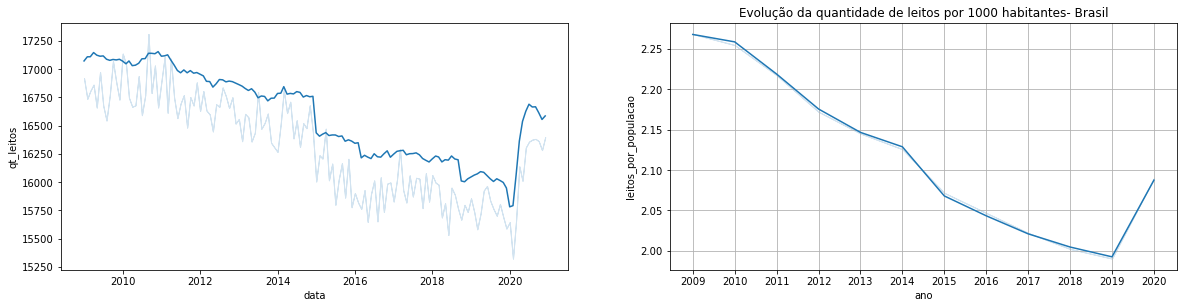

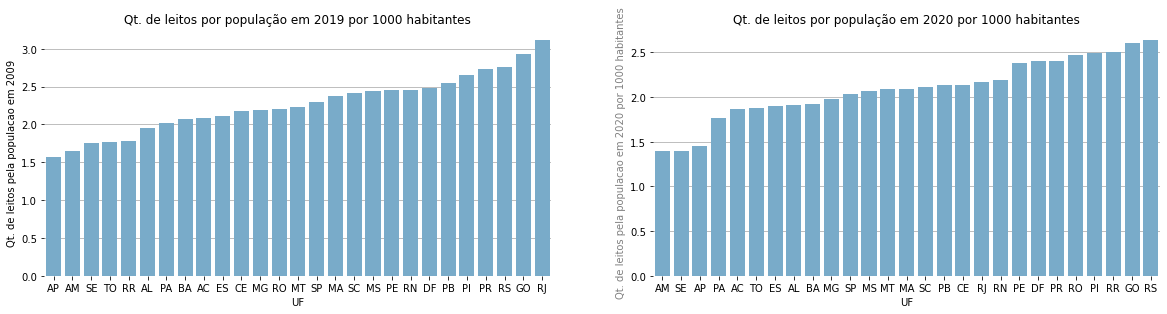

In [29]:
plt.figure(figsize=(20, 10))

ax3 = plt.subplot(2, 2, 1)
ax3 = sns.lineplot(data = leitos, x='data', y='qt_leitos', ci=False)

ax1 = plt.subplot(2, 2, 2)
sns.lineplot(data = leitos_por_populacao, y='leitos_por_populacao', x='ano', ci=False)
plt.title('Evolução da quantidade de leitos por 1000 habitantes- Brasil')
plt.grid(True)


plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2, 2, 1)

ax1 = sns.barplot(data = leitos_por_populacao[leitos_por_populacao['ano'] == '2009'].sort_values(by='leitos_por_populacao'), 
                  x='uf', y ='leitos_por_populacao', hue='ano', palette='Blues_r')
plt.xlabel('UF')
plt.ylabel('Qt. de leitos pela populacao em 2009')
plt.title('Qt. de leitos por população em 2019 por 1000 habitantes')
ax1.grid(axis='y')
ax1.set_axisbelow(True)
sns.despine(bottom = True, left=True)
ax1.legend().set_visible(False)


ax2 = plt.subplot(2, 2, 2)


ax = sns.barplot(data = leitos_por_populacao[leitos_por_populacao['ano'] == '2020'].sort_values(by='leitos_por_populacao'), 
                 x='uf', y ='leitos_por_populacao', hue='ano', palette='Blues_r')
plt.xlabel('UF')
plt.ylabel('Qt. de leitos pela populacao em 2020 por 1000 habitantes', color = 'grey')
plt.title('Qt. de leitos por população em 2020 por 1000 habitantes')
ax2.grid(axis='y')
ax2.set_axisbelow(True)
sns.despine(bottom = True, left=True)
ax2.legend().set_visible(False)

ax;

### INTERNAÇÕES 

In [30]:
# ajustando o nome dos estados
internacoes.reset_index(inplace = True)
internacoes['Região/Unidade da Federação'].replace('.. ', '', inplace = True, regex=True)

# Inserindo a coluna com uf
internacoes['uf'] = internacoes['Região/Unidade da Federação'].map(siglas)

# transformando 'uf' em index
internacoes.set_index('uf', inplace=True)

# Excluindo a coluna leitos
internacoes.drop(columns=(['Região/Unidade da Federação', 'Total']), inplace=True)

# Slice do ano
# Criando a coluna ano
internacoes = internacoes.T.reset_index()
internacoes['ano'] = internacoes['index'].str.slice(start = 0, stop = 4)

# Criando a coluna do mes
internacoes['mes'] = internacoes['index'].str.slice(start = 5, stop = 8)

# traduzinho os meses
internacoes['mes'] = internacoes['mes'].map(meses_port_ing)

# Concatenando o ano e mes
internacoes['data'] = internacoes['ano'] + "-" + internacoes['mes']

# Alterando o tipo de dado
internacoes['data'] = pd.to_datetime(internacoes['data'])

# removendo as colunas
internacoes.drop(columns=(['index', 'ano', 'mes']), inplace = True)

# Fazendo melt
internacoes = internacoes.melt(id_vars='data', value_name='qt_internacoes')

# Criando a coluna de mes e ano
internacoes['mes'] = internacoes['data'].dt.month
internacoes['ano'] = internacoes['data'].dt.year


internacoes



,data,uf,qt_internacoes,mes,ano
0,2009-01-01,RO,5891,1,2009
1,2009-02-01,RO,6608,2,2009
2,2009-03-01,RO,6950,3,2009
3,2009-04-01,RO,6857,4,2009
4,2009-05-01,RO,7343,5,2009
...,...,...,...,...,...
3856,2020-07-01,DF,14999,7,2020
3857,2020-08-01,DF,15121,8,2020
3858,2020-09-01,DF,14127,9,2020
3859,2020-10-01,DF,15043,10,2020


In [31]:
# Criando uma coluna considerando a qt. de leitos no mes 12
internacoes_ano = internacoes[internacoes['mes'] == 11]
internacoes_ano.drop(columns=(['data', 'mes']), inplace = True)

# Criando um 'contador' que servirá como chave
internacoes_ano = internacoes_ano.sort_values(by=['uf', 'ano'])
internacoes_ano['contador'] = [num for num in np.arange(0,len(internacoes_ano))]

# selecionando as colunas alvo
internacoes_por_populacao = populacao[['uf', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020']]

# Fazendo melt
internacoes_por_populacao = internacoes_por_populacao.melt(id_vars='uf', var_name='ano', value_name='populacao')

# Criando contador para servir de chave
internacoes_por_populacao = internacoes_por_populacao.sort_values(by=['uf', 'ano'])
internacoes_por_populacao['contador'] = [num for num in np.arange(0,len(internacoes_por_populacao))]

# Fazendo merge
internacoes_por_populacao = internacoes_por_populacao.merge(internacoes_ano[['qt_internacoes', 'contador']], how='inner', on='contador')
internacoes_por_populacao.drop(columns=('contador'), inplace=True)

# Calculo da quantidade de leitos por populacao
internacoes_por_populacao['internacoes_por_populacao'] = (internacoes_por_populacao['qt_internacoes'] / internacoes_por_populacao['populacao']) * 1000

# Corrigindo valor faltante
internacoes['qt_internacoes'].replace('-', 2194, inplace = True)

# Alterando tipo de dado
internacoes['qt_internacoes'] = internacoes['qt_internacoes'].astype(int)
internacoes_por_populacao['qt_internacoes'] = internacoes_por_populacao['qt_internacoes'].astype(int)
internacoes_por_populacao['internacoes_por_populacao'] = internacoes_por_populacao['internacoes_por_populacao'].astype(float)

internacoes_por_populacao

,uf,ano,populacao,qt_internacoes,internacoes_por_populacao
0,AC,2009,720132.0,1888,2.621742
1,AC,2010,734447.0,2097,2.855209
2,AC,2011,748616.0,2538,3.390256
3,AC,2012,762631.0,2916,3.823605
4,AC,2013,776463.0,2421,3.117985
...,...,...,...,...,...
319,TO,2016,1532902.0,5960,3.888050
320,TO,2017,1550194.0,5269,3.398929
321,TO,2018,1567016.0,4661,2.974443
322,TO,2019,1583391.0,5670,3.580922


Text(0.5, 1.0, 'Quantidade de internacoes no Brasil até 2019')

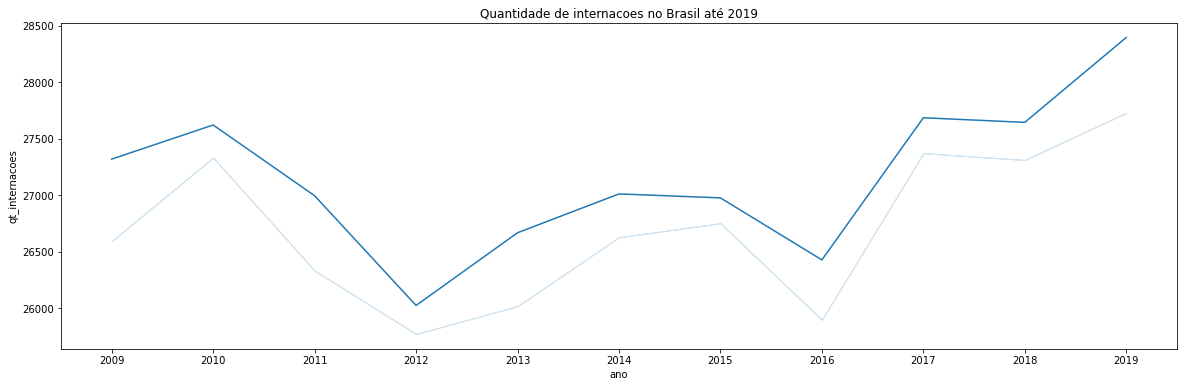

In [32]:
plt.figure(figsize=(20, 6))

ax = sns.lineplot(data = internacoes_por_populacao[internacoes_por_populacao['ano'] != '2020'], x='ano', y='qt_internacoes', ci=False)
plt.title('Quantidade de internacoes no Brasil até 2019')


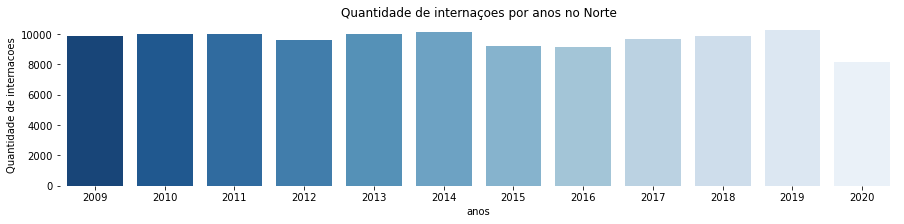

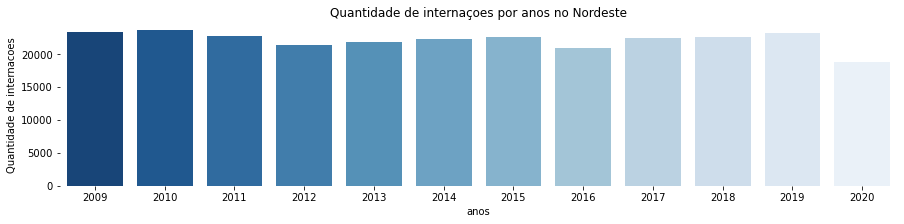

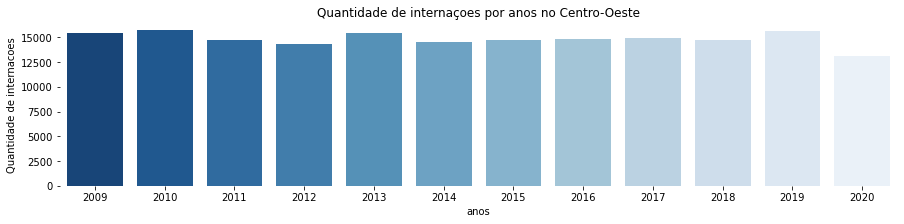

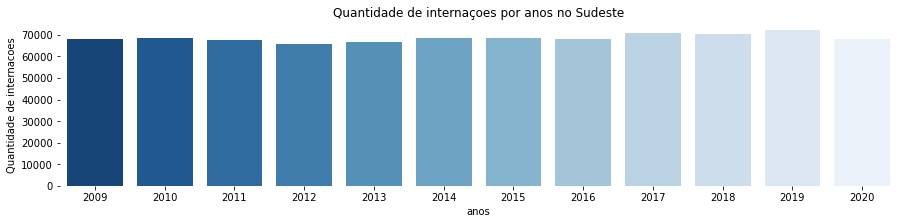

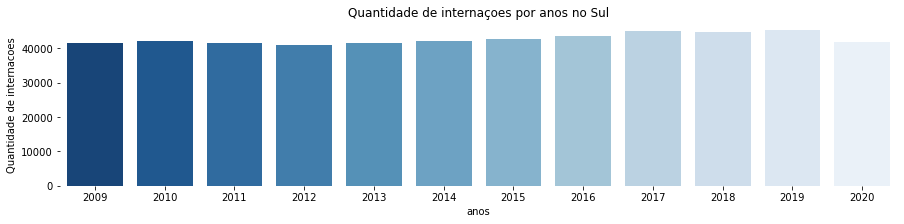

In [33]:
# Classificando as regioes
regioes = covid[['regiao', 'estado']].drop_duplicates()
regioes.rename(columns={'estado' : 'uf'}, inplace=True)
internacoes_por_populacao = internacoes_por_populacao.merge(regioes, on='uf', how='inner')


for u in internacoes_por_populacao.regiao.drop_duplicates(): 
    plt.figure(figsize=(15, 3))
    sns.barplot(data = internacoes_por_populacao[internacoes_por_populacao['regiao'] == u], y='qt_internacoes',
               x='ano', palette='Blues_r', ci=None)
    plt.xlabel('anos')
    plt.ylabel('Quantidade de internacoes')
    plt.title('Quantidade de internaçoes por anos no {}'.format(u))
    sns.despine(bottom=True, left = True)

## SÉRIE TEMPORAL - COVID

**MODELO ADITIVO**: Quando o elemento sazonal ou tendência não é proporcional com o nível da série

**MODELO MULTIPLICATIVO**: Quando o elemento sazonal ou tendência muda com o nível da série

**NÍVEL**: Média da série temporal

***

**RESÍDUOS**

Importantes para análise do modelo

Não devem ser relacionados

Se existe autocorrelação, existe informação nos resíduos que deveria ser utilizada na previsão 

Média deve ser aproximadamente zero

- Variância constante
- Distribuídos em uma normal

(Ljung–Box test)

***

Hold out

***

Série estacionária: A média e a variância se mantêm constantes durante o tempo. Séries com tendências e sazonalidades, em geral, não são estacionárias (somente sazonais, podem ser estacionárias)

### MÉDIA MÓVEL

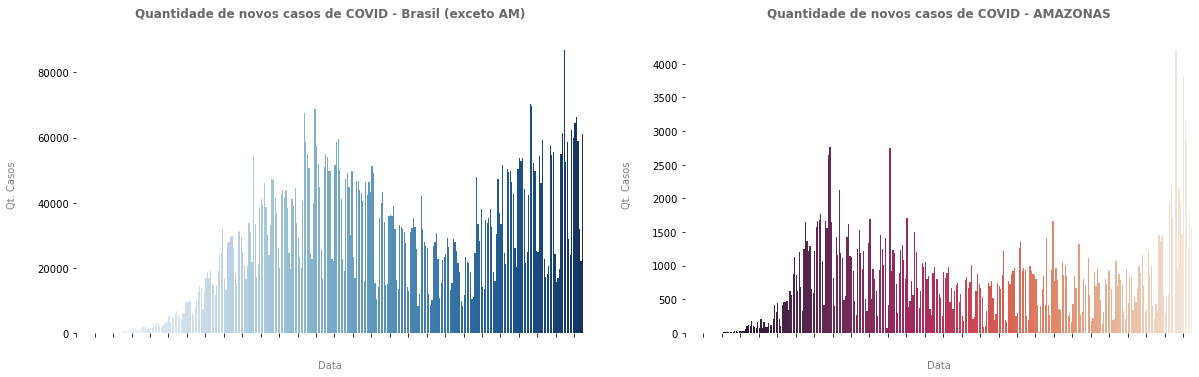

In [34]:
covid_br = covid[covid['estado'] != 'AM']
covid_am = covid[covid['estado'] == 'AM']

plt.figure(figsize=(20, 12))
ax = plt.subplot(2, 2, 1)

ax = sns.barplot(data = covid_br, x='data', y='casosNovos', palette='Blues', ci = False, estimator=sum)
plt.title('Quantidade de novos casos de COVID - Brasil (exceto AM)', color = 'dimgrey', fontweight = 'bold', size = 12, pad = 20)
plt.xlabel('Data', color='grey', labelpad=20)
plt.ylabel('Qt. Casos', color='grey', labelpad=20)
sns.despine(bottom = True, left=True)

ax.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset=0))

ax2 = plt.subplot(2,2,2)

ax2 = sns.barplot(data = covid_am, x='data', y='casosNovos', palette='rocket', ci = False, estimator=sum)
plt.title('Quantidade de novos casos de COVID - AMAZONAS', color = 'dimgrey', fontweight='bold', size = 12, pad = 20)
plt.xlabel('Data', color='grey', labelpad=20)
plt.ylabel('Qt. Casos', color='grey', labelpad=20)
sns.despine(bottom = True, left=True)

ax2.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset=0))


#### MÉDIA MÓVEL - BRASIL

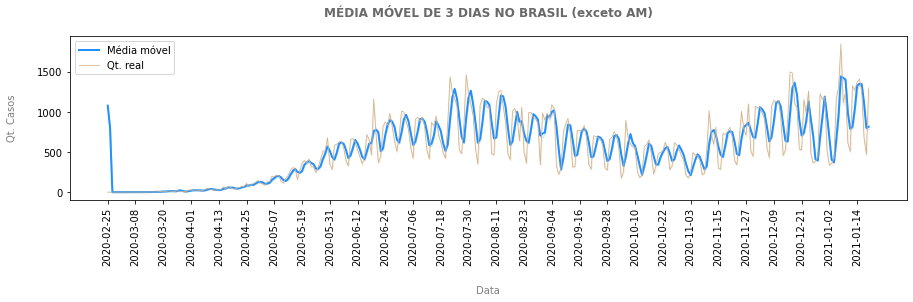

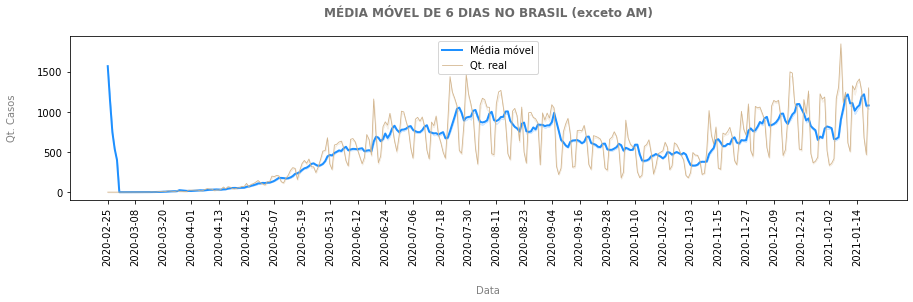

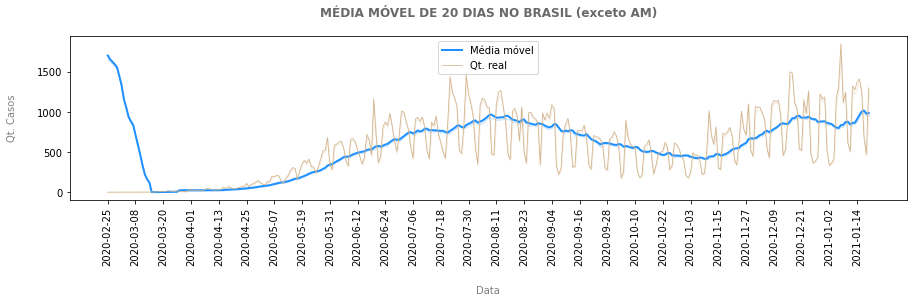

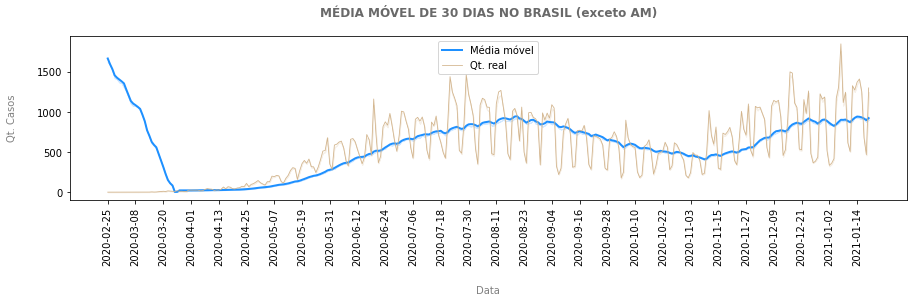

In [36]:
periodos= [3, 6, 20, 30]


for m in periodos:
    plt.figure(figsize=(15, 3))
    covid_br_MM = covid_br[['data', 'casosNovos']]
    covid_br_MM['MM_{}'.format(m)] = covid_br_MM['casosNovos'].rolling(m).mean()
    
    ax = sns.lineplot(data = covid_br_MM, x='data', y='MM_{}'.format(m), color = 'dodgerblue', linewidth=2,
                     label='Média móvel', ci=False)
    sns.lineplot(data=covid_br, x='data', y='casosNovos', color = 'tan', linewidth=0.8, label='Qt. real',
                ci=False)
    plt.title('MÉDIA MÓVEL DE {} DIAS NO BRASIL (exceto AM)'.format(m), color = 'dimgrey', fontweight='bold', 
              size = 12, pad = 20)
    plt.xlabel('Data', color='grey', labelpad=20)
    plt.ylabel('Qt. Casos', color='grey', labelpad=20)
    plt.grid(False)
    plt.xticks(rotation=90)
    ax.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset=0))
    

#### MÉDIA MOVEL - AMAZONAS

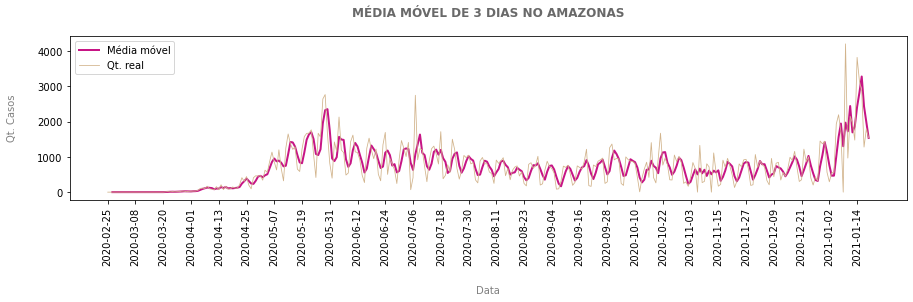

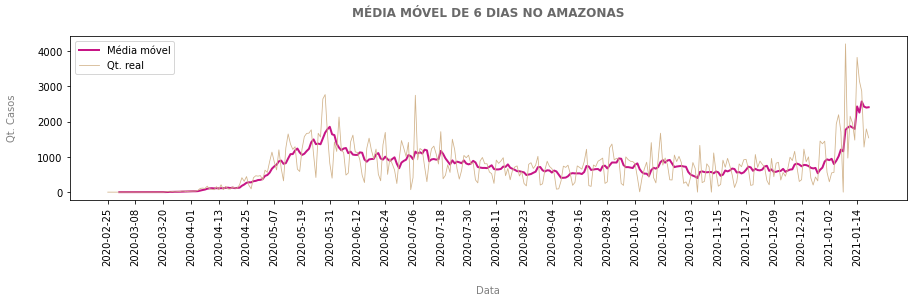

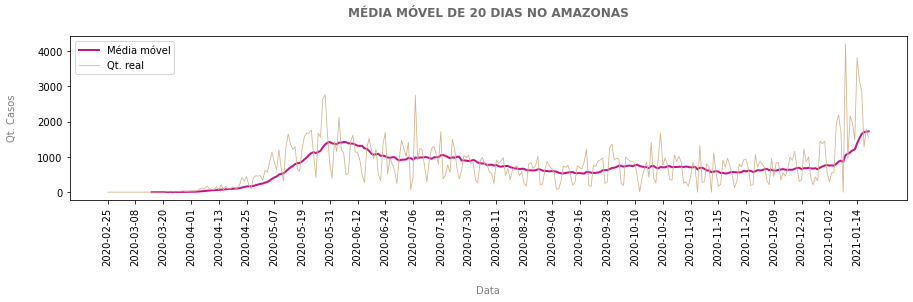

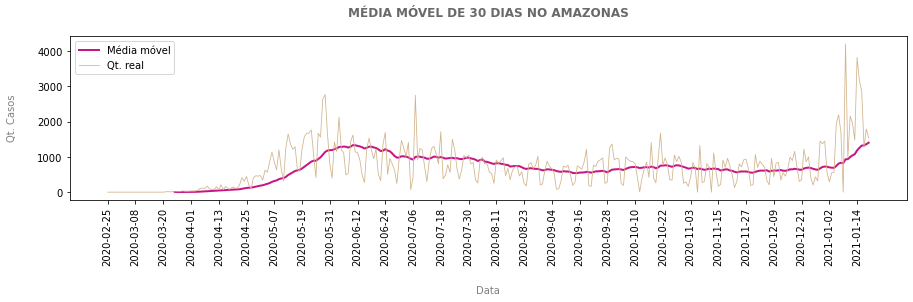

In [37]:
for m in periodos:
    plt.figure(figsize=(15, 3))
    covid_am_MM = covid_am[['data', 'casosNovos']]
    covid_am_MM['MM_{}'.format(m)] = covid_am_MM['casosNovos'].rolling(m).mean()
    
    ax = sns.lineplot(data = covid_am_MM, x='data', y='MM_{}'.format(m), color = 'mediumvioletred', linewidth=2,
                     label='Média móvel', ci=False)
    sns.lineplot(data=covid_am, x='data', y='casosNovos', color = 'tan', linewidth=0.8, label='Qt. real', 
                 ci=False)
    plt.title('MÉDIA MÓVEL DE {} DIAS NO AMAZONAS'.format(m), color = 'dimgrey', fontweight='bold', size = 12, pad = 20)
    plt.xlabel('Data', color='grey', labelpad=20)
    plt.ylabel('Qt. Casos', color='grey', labelpad=20)
    plt.grid(False)
    plt.xticks(rotation=90)
    ax.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset=0))
    

### DECOMPOSIÇÃO DA SÉRIE TEMPORAL

#### DECOMPOSIÇÃO CASOS EM SP


 - - - - - - - Decomposição da Serie Temporal de casos de COVID-19 no Brasil (exceto AM) (freq: 30) - - - - - - - -


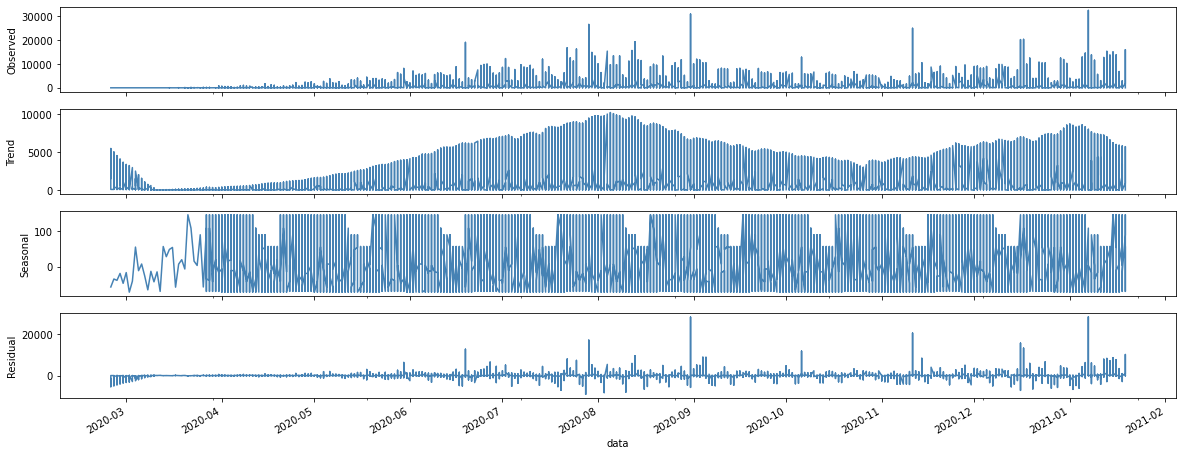

In [38]:
decomposicaobr = seasonal_decompose(covid_br[['data', 'casosNovos']].set_index('data'), model = 'aditive', freq=30)

fig, axes = plt.subplots(4, 1, sharex=True)

print('')
print(' - - - - - - - Decomposição da Serie Temporal de casos de COVID-19 no Brasil (exceto AM) (freq: 30) - - - - - - - -')
decomposicaobr.observed.plot(ax=axes[0], legend=False, color='steelblue', figsize=(20,8)) 
axes[0].set_ylabel('Observed')

decomposicaobr.trend.plot(ax=axes[1], legend=False, color='steelblue')
axes[1].set_ylabel('Trend')

decomposicaobr.seasonal.plot(ax=axes[2],  legend=False,  color='steelblue')
axes[2].set_ylabel('Seasonal')

decomposicaobr.resid.plot(ax=axes[3], legend=False, color='steelblue')
axes[3].set_ylabel('Residual');


      Decomposição da Serie Temporal de casos de COVID-19 no Brasil (exceto AM) (freq: 30)     
          ---- Modelo Multiplicativo com comparação dos resíduos no modelo aditivo ---- 


''

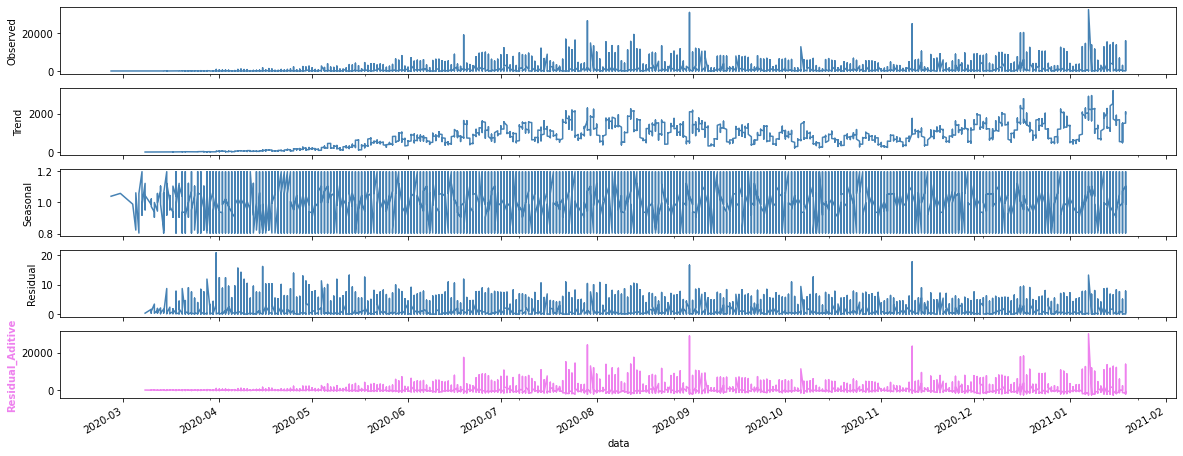

In [39]:
decomposicaobr = seasonal_decompose(covid_br[covid_br['casosNovos'] > 0][['data', 'casosNovos']].set_index('data').sort_index(), 
                                    model = 'multiplicative', freq=30)

decomposicaom = seasonal_decompose(covid_br[covid_br['casosNovos'] > 0][['data', 'casosNovos']].set_index('data').sort_index(), 
                                    model = 'aditive', freq=30)


fig, axes = plt.subplots(5, 1, sharex=True)

print('')
print('      Decomposição da Serie Temporal de casos de COVID-19 no Brasil (exceto AM) (freq: 30)     ')
print('          ---- Modelo Multiplicativo com comparação dos resíduos no modelo aditivo ---- ')

decomposicaobr.observed.plot(ax=axes[0], legend=False, color='steelblue', figsize=(20,8)) 
axes[0].set_ylabel('Observed')
decomposicaobr.trend.plot(ax=axes[1], legend=False, color='steelblue')
axes[1].set_ylabel('Trend')
decomposicaobr.seasonal.plot(ax=axes[2], legend=False, color='steelblue', figsize=(20,8))
axes[2].set_ylabel('Seasonal')
decomposicaobr.resid.plot(ax=axes[3], legend=False, color='steelblue')
axes[3].set_ylabel('Residual');

decomposicaom.resid.plot(ax=axes[4], legend=False, color='violet')
axes[4].set_ylabel('Residual_Aditive', color = 'violet', fontweight ='bold')
;

Sazonalidade do Brasil


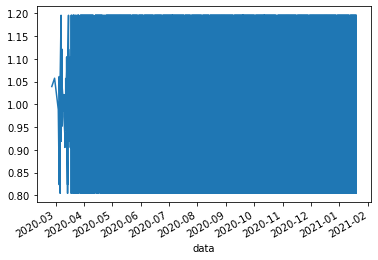

In [40]:
print('Sazonalidade do Brasil')

decomposicaobr.seasonal.plot();

#### DECOMPOSIÇÃO CASOS NO AM


 - - - - - - - - - Decomposição da Serie Temporal de casos de COVID-19 no Amazonas (freq: 30) - - - - - - - - -


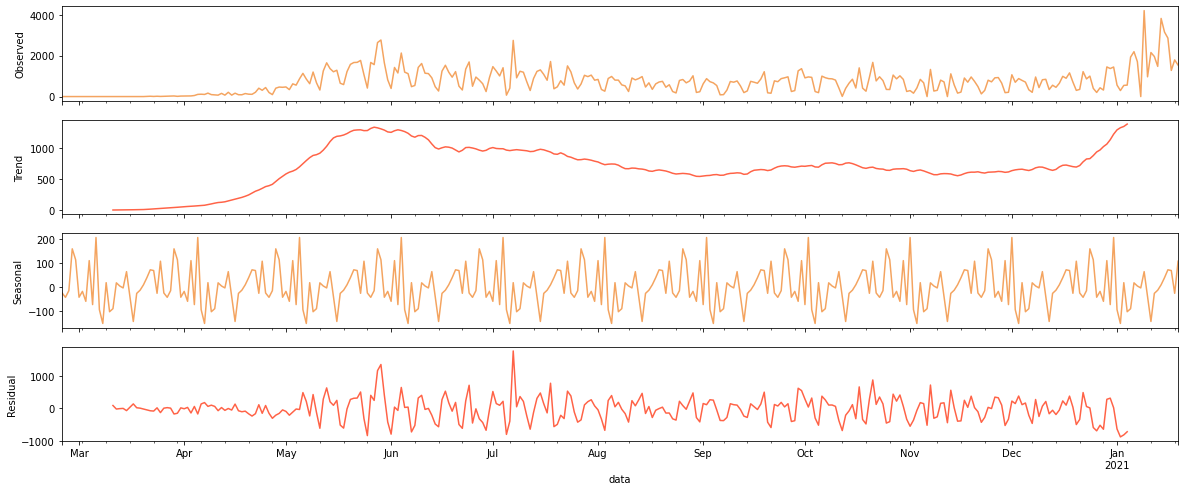

In [41]:
decomposicaoam = seasonal_decompose(covid_am[['data', 'casosNovos']].set_index('data'), model = 'aditive', freq=30)

fig, axes = plt.subplots(4, 1, sharex=True)

print('')
print(' - - - - - - - - - Decomposição da Serie Temporal de casos de COVID-19 no Amazonas (freq: 30) - - - - - - - - -')
decomposicaoam.observed.plot(ax=axes[0], legend=False, color='sandybrown', figsize=(20,8)) 
axes[0].set_ylabel('Observed')
decomposicaoam.trend.plot(ax=axes[1], legend=False, color='tomato')
axes[1].set_ylabel('Trend')
decomposicaoam.seasonal.plot(ax=axes[2], legend=False, color='sandybrown', figsize=(20,8))
axes[2].set_ylabel('Seasonal')
decomposicaoam.resid.plot(ax=axes[3], legend=False, color='tomato')
axes[3].set_ylabel('Residual');


      Decomposição da Serie Temporal de casos de COVID-19 No Amazonas (freq: 30)     
          ---- Modelo Multiplicativo com comparação dos resíduos no modelo aditivo ---- 


''

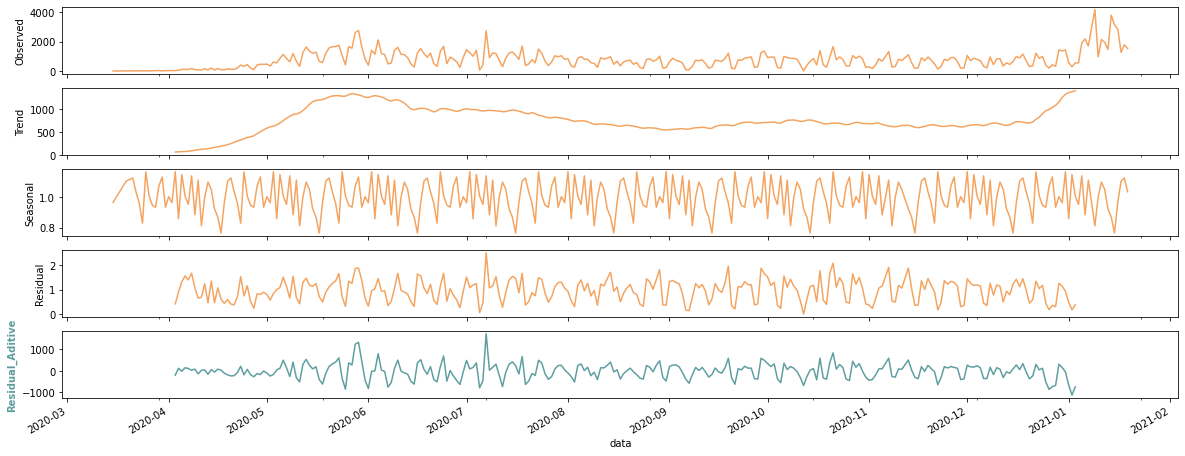

In [42]:
decomposicaobr = seasonal_decompose(covid_am[covid_am['casosNovos'] > 0][['data', 'casosNovos']].set_index('data').sort_index(), 
                                    model = 'multiplicative', freq=30)

decomposicaom = seasonal_decompose(covid_am[covid_am['casosNovos'] > 0][['data', 'casosNovos']].set_index('data').sort_index(), 
                                    model = 'aditive', freq=30)


fig, axes = plt.subplots(5, 1, sharex=True)

print('')
print('      Decomposição da Serie Temporal de casos de COVID-19 No Amazonas (freq: 30)     ')
print('          ---- Modelo Multiplicativo com comparação dos resíduos no modelo aditivo ---- ')

decomposicaobr.observed.plot(ax=axes[0], legend=False, color='sandybrown', figsize=(20,8)) 
axes[0].set_ylabel('Observed')
decomposicaobr.trend.plot(ax=axes[1], legend=False, color='sandybrown')
axes[1].set_ylabel('Trend')
decomposicaobr.seasonal.plot(ax=axes[2], legend=False, color='sandybrown', figsize=(20,8))
axes[2].set_ylabel('Seasonal')
decomposicaobr.resid.plot(ax=axes[3], legend=False, color='sandybrown')
axes[3].set_ylabel('Residual');

decomposicaom.resid.plot(ax=axes[4], legend=False, color='cadetblue')
axes[4].set_ylabel('Residual_Aditive', color = 'cadetblue', fontweight ='bold')
;

Sazonalidade do AM


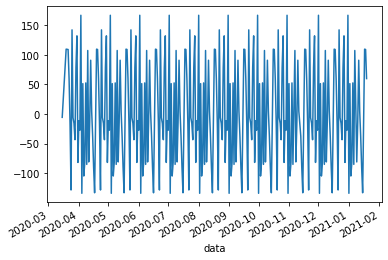

In [43]:
print('Sazonalidade do AM')
decomposicaom.seasonal.plot();

### TESTE DE ESTACIONARIEDADE

#### COVID BRASIL (exceção AM)

In [44]:
X = covid_br['casosNovos']
teste = adfuller(X)

print('ADF: %f' % teste[0])
print('Valor de P: %10f' % teste[1])
print('Valores Críticos:')
for i, value in teste[4].items():
    print('\t%s: %.3f' % (i, value))

ADF: -8.627915
Valor de P:   0.000000
Valores Críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567


####  COVID - AMAZONAS

In [45]:
X = covid_am['casosNovos']
teste = adfuller(X)

print('ADF: %f' % teste[0])
print('Valor de P: %f' % teste[1])
print('Valores Críticos:')
for i, value in teste[4].items():
    print('\t%s: %.3f' % (i, value))

ADF: -0.979987
Valor de P: 0.760493
Valores Críticos:
	1%: -3.451
	5%: -2.871
	10%: -2.572


### AUTOCORRELAÇÃO - ACF E PARTIAL ACF

#### ACF E PACF - BRASIL (EXCETO AM)

 
Autocorrelação e Autocorrelação Parcial dos casos de COVID no Brasil (exceto AM)


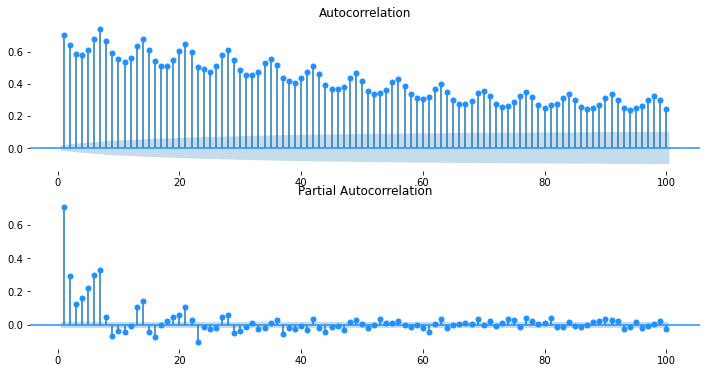

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6))

print(' ')
print('Autocorrelação e Autocorrelação Parcial dos casos de COVID no Brasil (exceto AM)')
plot_acf(covid_br['casosNovos'], lags= 100, zero=False, ax=ax1, color ='dodgerblue')
plt.box(False)
plot_pacf(covid_br['casosNovos'],lags= 100, zero=False, ax=ax2, color ='dodgerblue')
plt.box(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)


plt.show()

#### ACF E PACF - BRASIL (EXCETO AM)

 
Autocorrelação e Autocorrelação Parcial dos casos de COVID no Amazonas


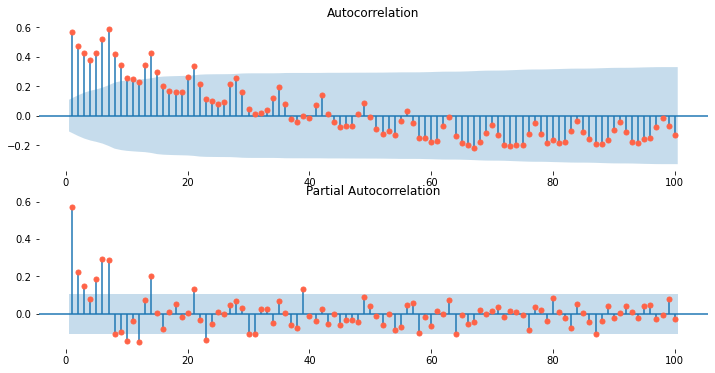

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6))
plt.box(False)

print(' ')
print('Autocorrelação e Autocorrelação Parcial dos casos de COVID no Amazonas')
plot_acf(covid_am['casosNovos'], lags= 100, zero=False, ax=ax1, markeredgecolor  = 'tomato', markerfacecolor ='tomato')
plot_pacf(covid_am['casosNovos'],lags= 100, zero=False, ax=ax2, markeredgecolor  = 'tomato', markerfacecolor ='tomato')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

plt.show()

## PREVISÕES DE SÉRIES TEMPORAIS

### HOLT WINTERS 

#### HOLT WINTERS - AM

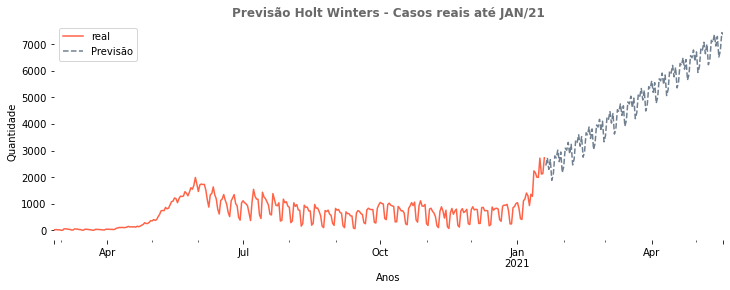

In [48]:
fit1 = ExponentialSmoothing(covid_am[['data', 'casosNovos']].set_index('data').sort_values(by='data'), 
                            seasonal_periods=7,
                            trend='additive', 
                            seasonal='additive').fit()

fit1.fittedvalues.plot(color='tomato', label = 'real', figsize=(12,4))
fit1.forecast(120).plot(color='slategrey', style ='--', label='Previsão')
plt.title('Previsão Holt Winters - Casos reais até JAN/21', color='dimgrey', fontweight='bold')
plt.legend()
sns.despine(bottom=True, left=True)
plt.ylabel('Quantidade', fontsize=10)
plt.xlabel('Anos', fontsize=10)

plt.show()

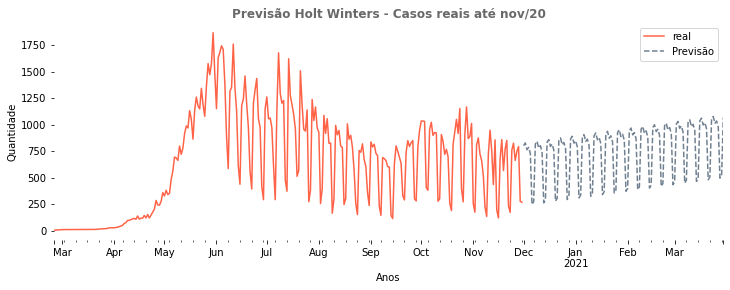

In [49]:
fit1 = ExponentialSmoothing(covid_am[['data', 'casosNovos']][:-50].set_index('data').sort_values(by='data'), 
                            seasonal_periods=7,
                            trend='additive', 
                            seasonal='additive').fit()

fit1.fittedvalues.plot(color='tomato', label = 'real', figsize=(12,4))
fit1.forecast(120).plot(color='slategrey', style ='--', label='Previsão')
plt.title('Previsão Holt Winters - Casos reais até nov/20', color='dimgrey', fontweight='bold')
plt.legend()
sns.despine(bottom=True, left=True)
plt.ylabel('Quantidade', fontsize=10)
plt.xlabel('Anos', fontsize=10)

plt.show()

 
Previsão dos casos de Covid19 no Amazonas dos meses de set a dez/20, 
comparando com os valores reais destes mesmos meses 



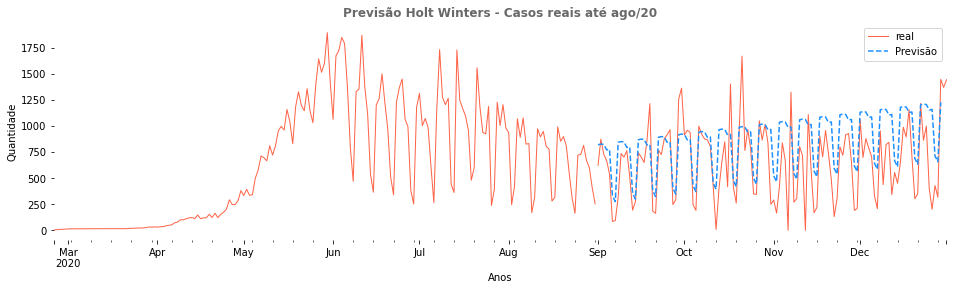

In [50]:
fit1 = ExponentialSmoothing(covid_am[['data', 'casosNovos']][:-141].set_index('data').sort_values(by='data'), 
                            seasonal_periods=7,
                            trend='additive', 
                            seasonal='additive').fit()


print(' \nPrevisão dos casos de Covid19 no Amazonas dos meses de set a dez/20, \ncomparando com os valores reais destes mesmos meses \n')
fit1.fittedvalues.plot(color='tomato', label = 'real', figsize=(16,4), linewidth = 1)

sns.lineplot(data=covid_am[['data', 'casosNovos']][189:-19].sort_values(by='data'), x='data', y='casosNovos',
            color='tomato', linewidth = 1)

fit1.forecast(120).plot(color='dodgerblue', style ='--', label='Previsão')

plt.title('Previsão Holt Winters - Casos reais até ago/20', color='dimgrey', fontweight='bold')
plt.legend()
sns.despine(bottom=True, left=True)
plt.ylabel('Quantidade', fontsize=10)
plt.xlabel('Anos', fontsize=10)

plt.show()

## ARIMA

#### ARIMA - AMAZONAS

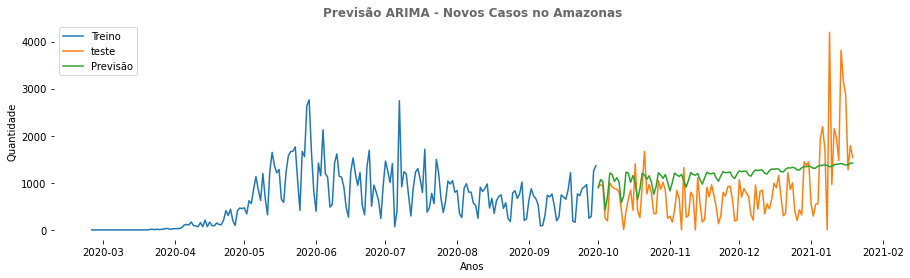

In [52]:
# Separando os dados de treino e teste
treino = covid_am[['data', 'casosNovos']][:-111].set_index('data').sort_values(by='data')
teste = covid_am[['data', 'casosNovos']][219:].set_index('data').sort_values(by='data')

# Treinando o modelo
modelo_arima = ARIMA(treino['casosNovos'].values, order=[15,1,0])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(111)[0]

# Comparando
plt.figure(figsize=(15, 4))

teste['previsao'] = previsao

sns.lineplot(x='data', y='casosNovos', data = treino, label ='Treino')
sns.lineplot(x='data', y='casosNovos', data = teste, label='teste') 
sns.lineplot(x='data', y='previsao', data=teste, label = 'Previsão')

plt.title('Previsão ARIMA - Novos Casos no Amazonas', color='dimgrey', fontweight='bold')
plt.legend()
sns.despine(bottom=True, left=True)
plt.ylabel('Quantidade', fontsize=10)
plt.xlabel('Anos', fontsize=10)

plt.show()

#### ARIMA - BRASIL (EXCETO AM) | POR MÊS

<Figure size 1080x288 with 0 Axes>

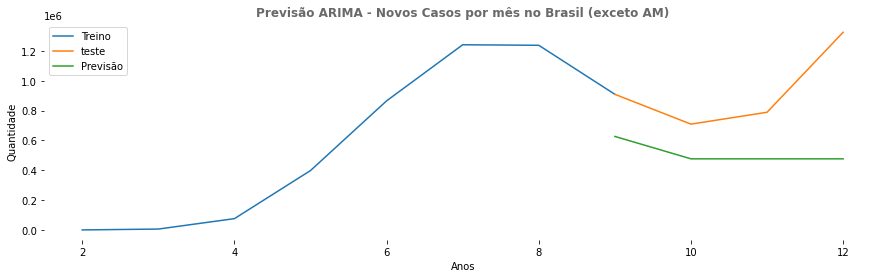

In [54]:
# Separando os dados de treino e teste
treino =  covid_br[covid_br['ano'] == 2020][['mes', 'casosNovos']].groupby('mes').sum()[:-3]
teste = covid_br[covid_br['ano'] == 2020][['mes', 'casosNovos']].groupby('mes').sum()[7:]

# Treinando o modelo
modelo_arima = ARIMA(treino['casosNovos'].values, order=[0,0,1])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(4)[0]

# Comparando
plt.figure(figsize=(15, 4))

teste['previsao'] = previsao

# Comparando
plt.figure(figsize=(15, 4))

teste['previsao'] = previsao

sns.lineplot(x='mes', y='casosNovos', data = treino, label ='Treino')
sns.lineplot(x='mes', y='casosNovos', data = teste, label='teste') 
sns.lineplot(x='mes', y='previsao', data=teste, label = 'Previsão')

plt.title('Previsão ARIMA - Novos Casos por mês no Brasil (exceto AM)', color='dimgrey', fontweight='bold')
plt.legend()
sns.despine(bottom=True, left=True)
plt.ylabel('Quantidade', fontsize=10)
plt.xlabel('Anos', fontsize=10)

plt.show()

## AUTOARIMA